### Human in the loop

Review for human in the loop, we often want to see our graph outputs as its running.

We laid the foundations for this with streaming.

Goals now, let's talk about the motivations for human in the loop:
- Approval: We can interrupt our agent, surface state to a user, and allow the user to accept an action.
- Debugging: We can rewind the graph to reporduce or avoid issues.
- Editing: You can modify the state.

LangGraph offers several ways to get or update agent state to support various human in the loop workflows.

In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI

load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [2]:
## Custom tools

def multiply(a: int, b: int) -> int:
    """Multiply a and b
    Args:
        a: First number
        b: Second number
    Returns:
        The product of the two numbers
    """
    return a * b

def add(a: int, b: int) -> int:
    """Add a and b
    Args:
        a: First number
        b: Second number
    Returns:
        The sum of the two numbers
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b
    Args:
        a: First number
        b: Second number
    Returns:
        The quotient of the two numbers
    """
    return a / b

tools = [multiply, add, divide]

In [3]:
## Integrate tools with LLM
llm_with_tools = llm.bind_tools(tools=tools)

In [39]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on set of numbers.")

def assistant(state: MessagesState):
    return {"messages": llm_with_tools.invoke([sys_msg] + state["messages"])}

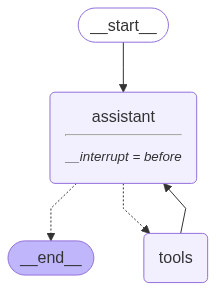

In [16]:
graph_builder = StateGraph(MessagesState)

graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = graph_builder.compile(interrupt_before=["assistant"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))


In [17]:
thread = {"configurable": {"thread_id": "123"}}

initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [18]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='51d28fe2-9865-40ae-9066-29a77230f6e5')]}, next=('assistant',), config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f05483b-fde5-6a1a-8000-0fec0a757ddb'}}, metadata={'source': 'loop', 'step': 0, 'parents': {}, 'thread_id': '123'}, created_at='2025-06-29T00:55:28.495460+00:00', parent_config={'configurable': {'thread_id': '123', 'checkpoint_ns': '', 'checkpoint_id': '1f05483b-fde3-6bac-bfff-cdd2baf2a339'}}, tasks=(PregelTask(id='f07e9a69-2702-e1d3-7ffe-b438032e64b7', name='assistant', path=('__pregel_pull', 'assistant'), error=None, interrupts=(), state=None, result=None),), interrupts=())

In [21]:
graph.get_state_history(thread)

<generator object Pregel.get_state_history at 0x10ce4a6c0>

In [22]:
## Continuing the execution without any new input.
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (call_wWEriWj5PsGsAdcozRMsOsI8)
 Call ID: call_wWEriWj5PsGsAdcozRMsOsI8
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [23]:
graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='51d28fe2-9865-40ae-9066-29a77230f6e5'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wWEriWj5PsGsAdcozRMsOsI8', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 181, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnapX2MXIeNYMWUgLFkHa4UpJNySR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8d4c7d39-8280-41ed-bbc7-ec9eb4ba747f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_wW

In [25]:
graph.get_state(thread).next

('assistant',)

In [26]:
## Continuing the execution without any new input.
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is 6.


In [27]:
graph.get_state(thread).next

()

### Edit human feedback

In [28]:
thread = {"configurable": {"thread_id": "123"}}

initial_input = {"messages": [HumanMessage(content="Multiply 2 and 3")]}

for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [29]:
graph.get_state(thread).next

('assistant',)

In [30]:
graph.update_state(thread, {"messages": [HumanMessage(content="No, please multiply 15 and 22")]})


{'configurable': {'thread_id': '123',
  'checkpoint_ns': '',
  'checkpoint_id': '1f054868-f992-6f9e-8006-f3cb92c7a131'}}

In [33]:
graph.get_state(thread).values

{'messages': [HumanMessage(content='Multiply 2 and 3', additional_kwargs={}, response_metadata={}, id='51d28fe2-9865-40ae-9066-29a77230f6e5'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_wWEriWj5PsGsAdcozRMsOsI8', 'function': {'arguments': '{"a":2,"b":3}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 181, 'total_tokens': 198, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BnapX2MXIeNYMWUgLFkHa4UpJNySR', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8d4c7d39-8280-41ed-bbc7-ec9eb4ba747f-0', tool_calls=[{'name': 'multiply', 'args': {'a': 2, 'b': 3}, 'id': 'call_wWEriWj5PsGsAdcozRMsO

In [35]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No, please multiply 15 and 22
================================== Ai Message ==================================
Tool Calls:
  multiply (call_RI2LpKAaWLvwoIZ8W7xl1qqQ)
 Call ID: call_RI2LpKAaWLvwoIZ8W7xl1qqQ
  Args:
    a: 15
    b: 22
================================= Tool Message =================================
Name: multiply

330


In [36]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

330
================================== Ai Message ==================================

The product of 15 and 22 is 330.


### Workflow will wait for user input.

In [41]:
from IPython.display import Image, display
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver

sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on set of numbers.")

def human_feedback(state: MessagesState):
    pass

def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

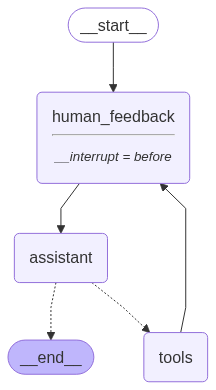

In [42]:
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("human_feedback", human_feedback)
graph_builder.add_node("assistant", assistant)
graph_builder.add_node("tools", ToolNode(tools))

graph_builder.add_edge(START, "human_feedback")
graph_builder.add_edge("human_feedback", "assistant")
graph_builder.add_conditional_edges("assistant", tools_condition)
graph_builder.add_edge("tools", "human_feedback")
graph_builder.add_edge("assistant", END)

memory = MemorySaver()
graph = graph_builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))